In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import directed_graphs
import torch.nn as nn
import torch.nn.functional as F
from tqdm import trange
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.has_mps else "cpu")

In [ ]:
def affinity_from_flow(flows, directions_array, flow_strength = 1, sigma=1):
  """Compute probabilities of transition in the given directions based on the flow. 

  Parameters
  ----------
  flows : torch tensor of shape n_points x n_dims
      _description_
  directions_array : torch tensor of shape n_directions x n_points x n_dims. Assumed to be normalized.
      _description_
  sigma : int, optional
      kernel bandwidth, by default 1
  returns (n_points)
  """
  assert len(flows.shape) == 2 # flows should only have one dimension
  assert len(directions_array.shape) > 1 and len(directions_array.shape) < 4
  n_directions = directions_array.shape[0]
  # Normalize directions
  length_of_directions = torch.linalg.norm(directions_array,dim=-1)
  normed_directions = F.normalize(directions_array,dim=-1)
  # and normalize flows # TODO: Perhaps reconsider
  # Calculate flow lengths, used to scale directions to flow
  # flow_lengths = torch.linalg.norm(flows,dim=-1)
  if len(directions_array) == 1: # convert to 2d array if necessary
    directions_array = directions_array[:,None] 
  # scale directions to have same norm as flow
  # scaled_directions = normed_directions * flow_lengths[:,None].repeat(directions_array.shape[0],1,directions_array.shape[2])
  # compute dot products as matrix multiplication
  dot_products = (normed_directions * flows).sum(-1)
  # take distance between flow projected onto direction and the direction
  distance_from_flow = (torch.linalg.norm(flows,dim=1)).repeat(n_directions,1) - dot_products
  # take absolute value
  distance_from_flow = torch.abs(distance_from_flow)
  # print('shape of dff',distance_from_flow.shape)
  # add to this the length of each direction
  distance_from_flow = flow_strength*distance_from_flow + length_of_directions
  # put the points on rows, directions in columns
  distance_from_flow = distance_from_flow.T
  # take kernel of distances
  kernel =  torch.exp(-distance_from_flow/sigma)
  return kernel

In [ ]:
def affinity_matrix_from_pointset_to_pointset(pointset1, pointset2, flows,n_neighbors=None,sigma=0.5, flow_strength=1):
  """Compute affinity matrix between the points of pointset1 and pointset2, using the provided flow.

  Parameters
  ----------
  pointset1 : torch tensor, n1 x d
      The first pointset, to calculate affinities *from*
  pointset2 : torch tensor, n2 x d
      The second pointset, to calculate affinities *to* (from pointset1)
  flow : a function that, when called at a point, gives the flow at that point
  n_neighbors : number of neighbors to include in affinity computations. All neighbors beyond it are given affinity zero
  (currently not implemented)

  Returns:
  Affinity matrix: torch tensor of shape n1 x n2
  """
  # Calculate the directions from point i in pointset 1 to point j in pointset 2
  n1 = pointset1.shape[0]
  n2 = pointset2.shape[0]
  P2 = pointset2[:,:,None].repeat(1,1,n1)
  P1 = pointset1.T.repeat(n2,1,1)
  P3 = (P2 - P1)
  P3 = P3.transpose(1,2)
  # compute affinities from flows and directions
  affinities = affinity_from_flow(flows,P3,sigma=sigma,flow_strength=flow_strength)
  return affinities

In [ ]:
class GaussianVectorField(nn.Module):
  def __init__(self,n_dims, n_gaussians, device, random_initalization = True):
    super(GaussianVectorField, self).__init__()
    self.n_dims = n_dims
    # each gaussian has a mean and a variance, which are initialized randomly, but
    # are afterwards tuned by the network
    self.means = torch.nn.Parameter(torch.rand(n_gaussians,n_dims)*8 - 4).to(device)
    if random_initalization:
      vecs = torch.randn(n_gaussians,n_dims)
    else:
      vecs = torch.ones(n_gaussians,n_dims)
    vecs = vecs / torch.linalg.norm(vecs, dim=1)[:,None]
    self.vectors = torch.nn.Parameter(vecs).to(device)
  def forward(self,points):
    # evaluates the vector field at each point
    # First, take distances between the points and the means
    dist_between_pts_and_means = torch.cdist(points,self.means)
    # print("distances between points and means",dist_between_pts_and_means)
    # apply kernel to this
    # creates n_points x n_means array
    kernel_from_mean = torch.exp(-(dist_between_pts_and_means**2))
    # print("kernalized",kernel_from_mean)
    # multiply kernel value by vectors associated with each Gaussian
    kernel_repeated = kernel_from_mean[:,:,None].repeat(1,1,self.n_dims)
    # print('kernel repeated has shape',kernel_repeated.shape, 'and vecs has shape', self.vectors.shape)
    kernel_times_vectors = kernel_repeated * self.vectors
    # creates tensor of shape
    # n_points x n_means x n_dims
    # collapse along dim 1 to sum vectors along dimension
    vector_field = kernel_times_vectors.sum(dim=1)
    return vector_field

In [ ]:
def anisotropic_kernel(D, sigma=0.7, alpha = 1):
  """Computes anisotropic kernel of given distances matrix.

  Parameters
  ----------
  D : ndarray or sparse
  sigma : float, optional
      Kernel bandwidth, by default 0.7
  alpha : int, optional
      Degree of density normalization, from 0 to 1; by default 1
  This is a good function.
  """
  W = torch.exp(-D**2/(2*sigma**2))
  # Additional normalization step for density
  D = torch.diag(1/(torch.sum(W,axis=1)**alpha)) 
  W = D @ W @ D
  return W

In [ ]:
from collections import OrderedDict
def FlowArtist(FA_type,dim = 2, num_gauss = 0, shape = [2,4,8,4,2], device = torch.device('cpu')):
    # Function to create tailored flow artist
    
    FA = nn.Sequential()
    
    if FA_type == "gaussian": # default = Gaussian model
        FA = GaussianVectorField(dim,num_gauss, device=device)
    elif FA_type == "ReLU": # ReLu
        d_len = len(shape)*2
        d = OrderedDict()
        d[str(0)] = nn.Linear(shape[0], shape[1])
        for i in range(1,d_len-3):
            if i%2 == 1:
                d[str(i)] = nn.LeakyReLU()
            else:
                d[str(i)] = nn.Linear(shape[int(i/2)], shape[int(i/2)+1])
        # create MLP
        FA = nn.Sequential(d)
        
    elif FA_type == "tanh": # ReLu dim,2,4,8,4,2,dim
        shape = [2,4,8,4,2]
        FA = nn.Sequential(nn.Linear(dim, shape[0]),
                           nn.tanh(),
                           nn.Linear(shape[0], shape[1]),
                           nn.tanh(),
                           nn.Linear(shape[1], shape[2]),
                           nn.tanh(),
                           nn.Linear(shape[2], shape[3]),
                           nn.tanh(),
                           nn.Linear(shape[3], shape[4]),
                           nn.tanh(),
                           nn.Linear(shape[4], dim))
        
    return FA

In [ ]:
def smoothness_of_vector_field(embedded_points, vector_field_function, device, use_grid = True, grid_width = 20):
  if use_grid:
    # find support of points
    minx = (min(embedded_points[:,0])-1).detach()
    maxx = (max(embedded_points[:,0])+1).detach()
    miny = (min(embedded_points[:,1])-1).detach()
    maxy = (max(embedded_points[:,1])+1).detach()
    # form grid around points
    x, y = torch.meshgrid(torch.linspace(minx,maxx,steps=grid_width),torch.linspace(miny,maxy,steps=grid_width))
    xy_t = torch.concat([x[:,:,None],y[:,:,None]],dim=2).float()
    xy_t = xy_t.reshape(grid_width**2,2).to(device)
    points_to_test = xy_t
  else:
    points_to_test = embedded_points
  # Compute distances between points
  # TODO: Can compute A analytically for grid graph, don't need to run kernel
  Dists = torch.cdist(points_to_test,points_to_test)
  A = anisotropic_kernel(Dists)
  # Get degree matrix and build graph laplacian
  D = A.sum(axis=1)
  L = torch.diag(D) - A
  # comment this out in production
  # plt.imshow(L)
  # print(L)
  # compute vector field at each grid point
  vecs = vector_field_function(points_to_test)
  x_vecs = vecs[:,0]
  y_vecs = vecs[:,1]
  # compute smoothness of each x and y and add them # TODO: There are other ways this could be done
  x_smoothness = (x_vecs.T @ L @ x_vecs) / torch.max(torch.linalg.norm(x_vecs)**2, torch.tensor(1e-5))
  y_smoothness = (y_vecs.T @ L @ y_vecs) / torch.max(torch.linalg.norm(y_vecs)**2, torch.tensor(1e-5))
  total_smoothness = x_smoothness + y_smoothness
  return total_smoothness

In [ ]:
def compute_grid(X,grid_width=20):
  """ Returns a grid of points which bounds the points X. 
  The grid has 'grid_width' dots in both length and width.
  Accepts X, tensor of shape n x 2
  Returns tensor of shape grid_width^2 x 2"""
  # TODO: This currently only supports 
  # find support of points
  minx = float(torch.min(X[:,0])-0.1) # TODO: use torch.min, try without detach
  maxx = float(torch.max(X[:,0])+0.1)
  miny = float(torch.min(X[:,1])-0.1)
  maxy = float(torch.max(X[:,1])+0.1)
  # form grid around points
  x, y = torch.meshgrid(torch.linspace(minx,maxx,steps=grid_width),torch.linspace(miny,maxy,steps=grid_width))
  xy_t = torch.concat([x[:,:,None],y[:,:,None]],dim=2).float()
  xy_t = xy_t.reshape(grid_width**2,2).detach()
  return xy_t

In [ ]:
def diffusion_matrix_with_grid_points(X, grid, flow_function, t, sigma,flow_strength):
  n_points = X.shape[0]
  # combine the points and the grid
  points_and_grid = torch.concat([X,grid],dim=0)
  # get flows at each point
  flow_per_point = flow_function(points_and_grid)
  # take a diffusion matrix
  A = affinity_matrix_from_pointset_to_pointset(points_and_grid,points_and_grid, flows = flow_per_point, sigma = sigma, flow_strength=flow_strength)
  P = F.normalize(A, p=1, dim=-1)
  # TODO: Should we remove self affinities? Probably not, as lazy random walks are advantageous when powering
  # Power the matrix to t steps
  Pt = torch.matrix_power(P,t)
  # Recover the transition probabilities between the points, and renormalize them
  Pt_points = Pt[:n_points,:n_points]
  # Pt_points = torch.diag(1/Pt_points.sum(1)) @ Pt_points
  Pt_points = F.normalize(Pt_points, p=1, dim=1)
  # return diffusion probs between points
  return Pt_points

In [ ]:
class FeedForwardReLU(nn.Module):
  def __init__(self, shape):
    super(FeedForwardReLU, self).__init__()
    d_len = len(shape)*2
    d = OrderedDict()
    d[str(0)] = nn.Linear(shape[0], shape[1])
    for i in range(1,d_len-3):
        if i%2 == 1:
            d[str(i)] = nn.LeakyReLU()
        else:
            d[str(i)] = nn.Linear(shape[int(i/2)], shape[int(i/2)+1])
    # create MLP
    self.FA = nn.Sequential(d)
  def forward(self, X):
    return self.FA(X)

In [ ]:
class MultiscaleDiffusionFlowEmbedder(torch.nn.Module):
    def __init__(self, 
                 X, 
                 flows, 
                 ts = (1,2,4,8), 
                 sigma_graph = 0.5,
                 sigma_embedding=0.5,
                 flow_strength_graph=5, 
                 flow_strength_embedding=5,
                 embedding_dimension=2,
                 learning_rate = 1e-3,
                 flow_artist = "ReLU",
                 flow_artist_shape = (2,4,8,4,2),
                 num_flow_gaussians = 25,
                 embedder = None,
                 decoder = None,
                 labels = None,
                 loss_weights = None,
                 device=torch.device('cpu'),
                ):
        # generate default parameters
        embedder = FeedForwardReLU(shape=(3,4,8,4,2)) if embedder is None else embedder
        decoder = FeedForwardReLU(shape=(2,4,8,4,3)) if decoder is None else decoder
        loss_weights = {
            "diffusion":1,
            "smoothness":0,
            "reconstruction":0,
            "diffusion map regularization":0,
            "flow cosine loss": 0,
        } if loss_weights is None else loss_weights

        # initialize parameters
        super(MultiscaleDiffusionFlowEmbedder, self).__init__()
        self.X = X
        self.ground_truth_flows = flows
        self.ts = ts
        self.sigma_embedding = sigma_embedding
        self.sigma_graph = sigma_graph
        self.nnodes = X.shape[0]
        self.data_dimension = X.shape[1]
        
        self.eps = 0.001
        self.loss_weights = loss_weights
        self.labels = labels
        self.flow_strength = torch.tensor(flow_strength_embedding).float()
        self.embedding_dimension = embedding_dimension
        # set device (used for shuffling points around during visualization)
        self.device = device
        # Used for 
        self.losses = {}
        for k in self.loss_weights.keys():
            self.losses[k] = []
        
        self.P_graph = affinity_matrix_from_pointset_to_pointset(X,X,flows,sigma=sigma_graph,flow_strength=flow_strength_graph)
        self.P_graph = F.normalize(self.P_graph, p=1, dim=1)
        # torch.diag(1/self.P_graph.sum(axis=1)) @ self.P_graph
        # compute matrix powers 
        # TODO: Could reuse previous powers to speed this up
        self.P_graph_ts = [torch.matrix_power(self.P_graph,t) for t in self.ts]
        self.P_embedding_ts = [None for i in self.ts]
        # Flow field
        self.FlowArtist = FlowArtist(flow_artist, dim=self.embedding_dimension, num_gauss = num_flow_gaussians, shape = flow_artist_shape, device = self.device).to(self.device)

        # Autoencoder to embed the points into a low dimension
        self.embedder = embedder.to(self.device)
        if decoder is not None:
            self.decoder = decoder.to(self.device)
        else:
            self.decoder = None

        # training ops
        self.KLD = nn.KLDivLoss(reduction='batchmean',log_target=False)
        self.MSE = nn.MSELoss()
        # self.KLD = homemade_KLD # when running on mac
        self.epsilon = 1e-6 # set zeros to eps
        self.optim = torch.optim.Adam(self.parameters(), lr = learning_rate)

    def diffusion_loss(self):
        # compute grid around points
        self.grid = compute_grid(self.embedded_points).to(self.device)
        # normalize embedded points to lie within -self.embedding_bounds, self.embedding_bounds
        # if any are trying to escape, constrain them to lie on the edges
        # self.embedded_points[:,0][torch.abs(self.embedded_points[:,0]) > self.embedding_bounds] = self.embedding_bounds * (self.embedded_points[:,0][torch.abs(self.embedded_points[:,0]) > self.embedding_bounds])/torch.abs(self.embedded_points[:,0][torch.abs(self.embedded_points[:,0]) > self.embedding_bounds])
        # self.embedded_points[:,1][torch.abs(self.embedded_points[:,1]) > self.embedding_bounds] = self.embedding_bounds * (self.embedded_points[:,1][torch.abs(self.embedded_points[:,1]) > self.embedding_bounds])/torch.abs(self.embedded_points[:,0][torch.abs(self.embedded_points[:,1]) > self.embedding_bounds])
        # compute embedding diffusion matrix, using including diffusion to grid points
        for i,t in enumerate(self.ts):
            self.P_embedding_ts[i] = diffusion_matrix_with_grid_points(X = self.embedded_points, grid=self.grid, flow_function = self.FlowArtist, t = t, sigma = self.sigma_embedding, flow_strength=self.flow_strength)
            # set any affinities of zero to a very small amount, to prevent the KL divergence from becoming infinite.
            self.P_embedding_ts[i][self.P_embedding_ts[i] == 0] = self.epsilon # TODO: Perhaps enable later; this didn't cause NaN errors before
            # self.P_embedding_ts[i] = self.P_embedding_ts[i] + self.epsilon
        # take KL divergence between P embedding ts and P graph ts
        diffusion_loss = 0
        for i in range(len(self.ts)):
            log_P_embedding_t = torch.log(self.P_embedding_ts[i])
            if log_P_embedding_t.is_sparse:
                diffusion_loss_for_t = self.KLD(log_P_embedding_t.to_dense(),self.P_graph_ts[i].to_dense())
            else:
                diffusion_loss_for_t = self.KLD(log_P_embedding_t,self.P_graph_ts[i])
            diffusion_loss += (2**(-i))*diffusion_loss_for_t
            # print(f"Diffusion loss {i} is {diffusion_loss}")
        self.losses['diffusion'].append(diffusion_loss)
        if diffusion_loss.isnan():
            raise NotImplementedError
        return diffusion_loss

    def loss(self):
        # embed points
        self.embedded_points = self.embedder(self.X)
        # compute diffusion loss on embedded points
        if self.diffusion_loss != 0:
            diffusion_loss = self.diffusion_loss()
        else:
            diffusion_loss = 0
        # compute autoencoder loss
        if self.decoder is not None:
            X_reconstructed = self.decoder(self.embedded_points)
            reconstruction_loss = self.MSE(X_reconstructed, self.X)
            self.losses['reconstruction'].append(reconstruction_loss)
        else:
            reconstruction_loss = 0
        # regularizations
        if self.loss_weights['smoothness'] != 0:
            smoothness_loss = smoothness_of_vector_field(self.embedded_points,self.FlowArtist,device=self.device,grid_width=20)
            self.losses['smoothness'].append(smoothness_loss)
        else:
            smoothness_loss = 0

        if self.loss_weights['diffusion map regularization'] != 0:
            diffmap_loss = diffusion_map_loss(self.P_graph_ts[0], self.embedded_points)
            self.losses['diffusion map regularization'].append(diffmap_loss)
        else:
            diffmap_loss = 0

        if self.loss_weights['flow cosine loss'] != 0:
            flow_loss = flow_cosine_loss(self.embedded_points, self.ground_truth_flows, self.FlowArtist(self.embedded_points))
            self.losses['flow cosine loss'].append(smoothness_loss)
        else:
            flow_loss = 0

        cost = self.loss_weights['diffusion']*diffusion_loss 
        + self.loss_weights['reconstruction']*reconstruction_loss 
        + self.loss_weights['smoothness']*smoothness_loss
        + self.loss_weights['diffusion map regularization']*diffmap_loss
        + self.loss_weights['flow cosine loss']*flow_loss
        return cost

    def visualize_points(self, labels = None):
        # controls the x and y axes of the plot
        # linspace(min on axis, max on axis, spacing on plot -- large number = more field arrows)
        if labels is None:
            labels = self.labels
        uv = self.FlowArtist(self.grid).detach().cpu()
        u = uv[:,0].cpu()
        v = uv[:,1].cpu()
        x = self.grid.detach().cpu()[:,0]
        y = self.grid.detach().cpu()[:,1]
        # quiver 
        #   plots a 2D field of arrows
        #   quiver([X, Y], U, V, [C], **kw); 
        #   X, Y define the arrow locations, U, V define the arrow directions, and C optionally sets the color.
        if labels is not None:
            sc = plt.scatter(self.embedded_points[:,0].detach().cpu(),self.embedded_points[:,1].detach().cpu(), c=labels)
            plt.legend()
        else:
            sc = plt.scatter(self.embedded_points[:,0].detach().cpu(),self.embedded_points[:,1].detach().cpu())
        plt.suptitle("Flow Embedding")
        plt.quiver(x,y,u,v)
        # Display all open figures.
        plt.show()

  
    def visualize_loss(self, loss_type = "total"):
        # diffusion_loss,reconstruction_loss, smoothness_loss
        x = []
        k = ""
        losses = {}
        for key in self.losses.keys():
            losses[key] = []
            k = key
        losses["total"] = []
        for i in range(len(self.losses["diffusion"])):
            x.append(i)
            for key in self.losses.keys():
                try:
                    losses[key].append(self.losses[key][i].detach().cpu().numpy())
                except:
                    losses[key].append(0)
        if loss_type == "all":
            for key in self.losses.keys():
                plt.plot(x, losses[key])
            plt.legend(self.losses.keys(), loc='upper right')
            plt.title("loss")
        else:
            plt.plot(x, losses[loss_type])
            plt.title(loss_type)

    def visualize_diffusion_matrices(self):
        fig, axs = plt.subplots(3,2, figsize=(10,15))
        axs[0][0].set_title(f"Ambient $P^{self.ts[0]}$")
        axs[0][0].imshow(self.P_graph_ts[0].detach().cpu().numpy())
        axs[0][1].set_title(f"Embedding $P^{self.ts[0]}$")
        axs[0][1].imshow(self.P_embedding_ts[0].detach().cpu().numpy())

        axs[1][0].set_title(f"Ambient $P^{self.ts[1]}$")
        axs[1][0].imshow(self.P_graph_ts[1].detach().cpu().numpy())
        axs[1][1].set_title(f"Embedding $P^{self.ts[1]}$")
        axs[1][1].imshow(self.P_embedding_ts[1].detach().cpu().numpy())

        axs[2][0].set_title(f"Ambient $P^{self.ts[2]}$")
        axs[2][0].imshow(self.P_graph_ts[2].detach().cpu().numpy())
        axs[2][1].set_title(f"Embedding $P^{self.ts[2]}$")
        axs[2][1].imshow(self.P_embedding_ts[2].detach().cpu().numpy())

        plt.show()

    def fit(self,n_steps = 1000):
        # train Flow Embedder on the provided graph
        self.train()
        # self.weight_of_flow = 0
        for step in trange(n_steps):
            # if step == 100:
            # 	self.weight_of_flow = 1
            # if step == 200:
            # 	self.weight_of_flow = 0.5
            self.optim.zero_grad()
            # compute loss
            loss = self.loss()
            if loss.isnan():
                print("Final loss was nan")
                raise NotImplementedError
            # print("loss is ",loss)
            # compute gradient and step backwards
            loss.backward()
            self.optim.step()
            if step % 500 == 0:
                print(f"EPOCH {step}. Loss {loss}. Flow strength {self.flow_strength}. Heatmap of P embedding is ")
                self.visualize_diffusion_matrices()
                self.visualize_points()
            # TODO: Criteria to automatically end training
        print("Exiting training with loss ",loss)
        return self.embedded_points

---

In [ ]:
from directed_graphs.datasets import directed_swiss_roll
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
X, flow, labels = directed_swiss_roll()
lw = {"diffusion":1,"smoothness":0,"reconstruction":0,"diffusion map regularization":0,"flow cosine loss":0}

In [ ]:
X = torch.tensor(X)
flow = torch.tensor(flow)
X = X.float().to(device)
flow = flow.float().to(device)

In [ ]:
MFE = MultiscaleDiffusionFlowEmbedder(X, flow, device=device, loss_weights=lw).to(device)

  0%|          | 0/200 [00:00<?, ?it/s]/gpfs/ysm/project/sumry2022/sumry2022_gt392/conda_envs/test/lib/python3.9/site-packages/torch/functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /opt/conda/conda-bld/pytorch_1646756402876/work/aten/src/ATen/native/TensorShape.cpp:2228.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


EPOCH 0. Loss 11.662160873413086. Flow strength 5.0. Heatmap of P embedding is 


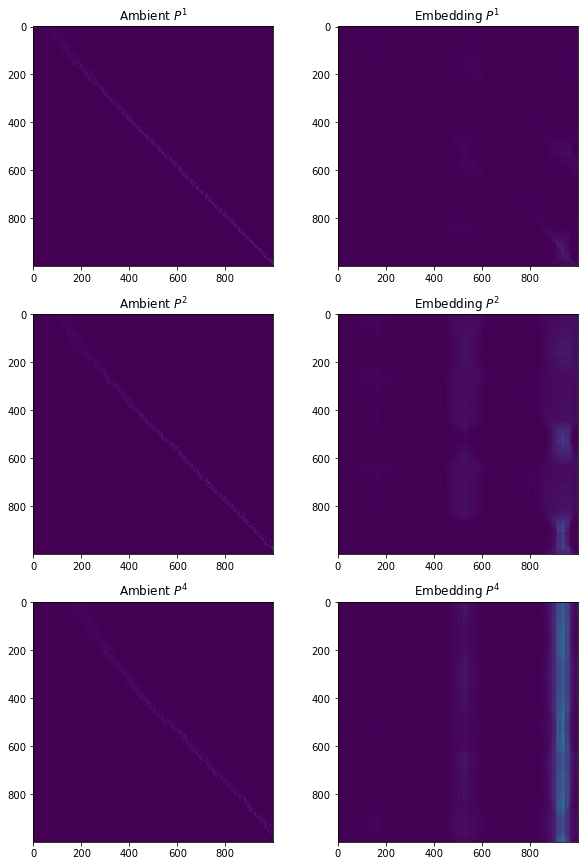

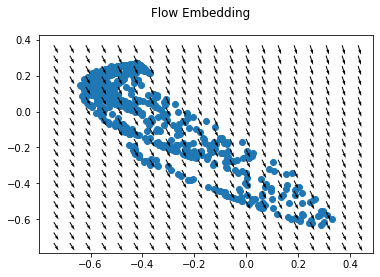

100%|██████████| 200/200 [00:11<00:00, 16.71it/s]


Exiting training with loss  tensor(8.9391, device='cuda:0', grad_fn=<MulBackward0>)


tensor([[-0.5498,  0.2089],
        [-0.5410,  0.2000],
        [-0.4265,  0.1147],
        ...,
        [ 0.4367, -0.7277],
        [ 0.4761, -0.7458],
        [ 0.1866, -0.5799]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [ ]:
MFE.fit(n_steps=200)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


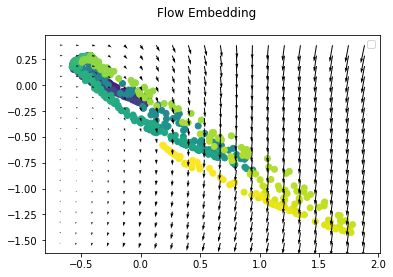

In [ ]:
MFE.visualize_points(labels)

---

In [ ]:
import torch

In [ ]:
A = torch.Tensor([[0,0],[2,0],[0,2]])
n = A.shape[0]
print(n)
print(A)

3
tensor([[0., 0.],
        [2., 0.],
        [0., 2.]])


In [ ]:
A1 = A.T.repeat(n,1,1)
A2 = A[:,:,None].repeat(1,1,n)

In [ ]:
A3 = (A2-A1)
A3 = A3.transpose(1,2)
A3

tensor([[[ 0.,  0.],
         [-2.,  0.],
         [ 0., -2.]],

        [[ 2.,  0.],
         [ 0.,  0.],
         [ 2., -2.]],

        [[ 0.,  2.],
         [-2.,  2.],
         [ 0.,  0.]]])

In [ ]:
length_of_directions = torch.linalg.norm(A3,dim=-1)
length_of_directions

tensor([[0.0000, 2.0000, 2.0000],
        [2.0000, 0.0000, 2.8284],
        [2.0000, 2.8284, 0.0000]])

In [ ]:
import torch.nn.functional as F
normed_directions = F.normalize(A3,dim=-1)
normed_directions

tensor([[[ 0.0000,  0.0000],
         [-1.0000,  0.0000],
         [ 0.0000, -1.0000]],

        [[ 1.0000,  0.0000],
         [ 0.0000,  0.0000],
         [ 0.7071, -0.7071]],

        [[ 0.0000,  1.0000],
         [-0.7071,  0.7071],
         [ 0.0000,  0.0000]]])

In [ ]:
flows = [[1,0],[1,0],[1,0]]

In [ ]:
dot_products = normed_directions*flows

TypeError: only integer tensors of a single element can be converted to an index